#### Lista 7

1. Abra o arquivo wideband.mat. Esse arquivo contém a gravação de 1 canal de registro 
eletrofisiológico do córtex somatosensorial primário de um rato. Os valores de wideband estão armazenados na variável data.lfp_samples{1}. Esse sinal foi adquirido com frequência de aquisição de 40 kHz. Separe o LFP (componentes de baixa freqência) das componentes de alta frequência e faça um gráfico do sinal wideband, baixas frequências e altas frequências (frequência de corte sugerida 500 Hz, mas fiquem à vontade para experimentar outros valores).

2. Faça uma janela de 1 s de qualquer parte do sinal. Defina um limiar de amplitude para selecionar as janelas do sinal de alta frequência onde podem conter spike. Um spike tem período da ordem de ms, portanto elabore janelas de 5 ms em torno do pico. Armazene as janelas em uma matriz onde as linhas são as repetições de spikes e as colunas o tempo (0 à 5 ms).

3. Tente separar spikes de formato de onda diferentes do ruído. Espera-se que no máximo um canal de aquisição consiga captar até 4 neurônios distintintos. Faça um filtro média para cada um dos neurônios encontrados e apresente a amplitude pico à pico e periodo do spike.  


### Imports and plot functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from scipy.io import loadmat
from scipy import signal


def plot_fft(y,title=None):
    """
    Plot fft for a given signal
    
    Adapted from: https://plot.ly/matplotlib/fft/
    """
    n = len(y) # length of the signal
    k = np.arange(n)
    T = n/fs
    frq = k/T # two sides frequency range
    frq = frq[:n//2] # one side frequency range

    Y = np.fft.fft(y)/(n/2) # fft computing and normalization
    Y = Y[:n//2]

    fig, ax = plt.subplots(2, 1, figsize=(15,4))

    time_lim = max(abs(y))*1.1
    time_lim = 1 if time_lim < 1 else time_lim
    ax[0].plot(t,y, scaley=False)
    ax[0].set_xlabel('Time')
    ax[0].set_ylim([-time_lim, time_lim])
    ax[0].set_ylabel('Amplitude')
    if title:
        ax[0].set_title(title)

    freq_lim = max(abs(Y))*1.1
    freq_lim = 1 if freq_lim < 1 else freq_lim
    ax[1].plot(frq,abs(Y),'r', scaley=False) # plotting the spectrum
    ax[1].set_ylim([0, freq_lim])
    ax[1].set_xlabel('Freq (Hz)')
    ax[1].set_ylabel('|Y(freq)|')

def plot_neurons(neurons):
    plt.figure(figsize=(11, 4))
    for i in range(4):
        plt.ylim([-50, 50])
        plt.subplot(2, 2, i+1)
        plt.subplots_adjust(hspace=0.5)
        plt.title(f'Neuron {i+1}')
        if neurons[i]:
            for j in neurons[i]:
                plt.plot(j)

### Load signal, filter signals

/home/yu/venvs/dsp/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


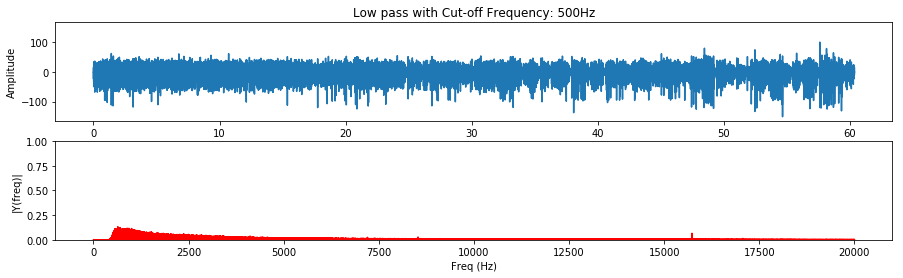

In [2]:
fs = 40000

fc = 500
filter_order = 10

data = loadmat('wideband.mat', squeeze_me=True, struct_as_record=False)
lfp = data['data'].lfp_samples[0]
total_time = len(lfp)/fs
t = np.arange(0, total_time, 1.0/fs)

w = fc / (fs / 2) # Normalize the frequency
b, a = signal.butter(filter_order, w, 'high')
spikes_signal = signal.filtfilt(b, a, lfp)

b, a = signal.butter(filter_order, w, 'low')
filtered_lfp = signal.filtfilt(b, a, lfp)

# Amplifying spikes
spikes_signal = spikes_signal*100
plot_fft(spikes_signal, f'Low pass with Cut-off Frequency: {fc}Hz')

### Getting peaks from 1 sec window at 10 sec

In [3]:
# signal at 10s
ten_sec = 10*fs
window = 1
one_sec_spikes = spikes_signal[ten_sec:ten_sec+(window*fs)]

# 5 ms N samples
window_samples = int(0.005*fs)
half_window = window_samples//2

peaks, _ = signal.find_peaks(one_sec_spikes, height=24, distance=window_samples)
len(peaks)

36

### Visualizing all spikes (not sorted) 

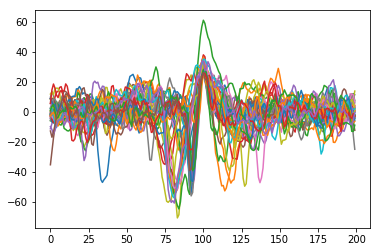

In [4]:
spikes = [one_sec_spikes[idx-half_window:idx+half_window] for idx in peaks]
for spike in spikes:
    plt.plot(spike)

### Manual Spike Sorting

HOWTO:
1. Run
2. Input wanted maximum number of spikes
3. Select from 1 to 4 for spike, or discard (5) for each spike

Final Result: 


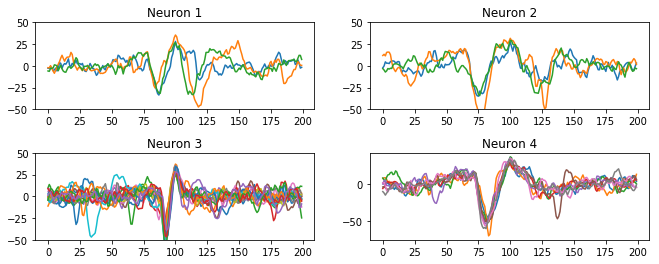

In [5]:
# Initializing neuron matrices
neurons = [[] for _ in range(4)]

maximum = int(input('Please give the maximum number of spikes you want to sort'))

for spike in spikes[:maximum]:
    clear_output()
    plot_neurons(neurons)
    plt.figure(figsize=(10, 4))
    plt.plot(spike)
    plt.ylim([-50, 50])
    plt.show()

    x = 0
    while x not in range(1, 6):
        try:
            x = int(input('Add above signal to Neuron (1-4). 5 to Discard: '))
            if x > 5 or x < 1:
                print('Input should be 1 to 5')
        except ValueError:
            print('Wrong input')
            x = 0

    if x == 5:
        continue

    neurons[x-1].append(spike)

clear_output()
print('Final Result: ')
plot_neurons(neurons)

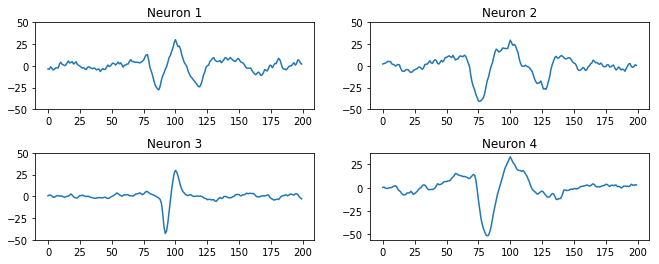

In [6]:
neurons_mean = [[list(np.mean(n, axis=0))] for n in neurons]
plot_neurons(neurons_mean)

### Approximate latency by visualization:
- Neuron 1: 80
- Neuron 2: 65
- Neuron 3: 90
- Neuron 4: 70

### Peak to peak amplitude:

In [7]:
unpacked = [nm[0] for nm in neurons_mean]

for i in range(len(unpacked)):
    top, bottom = max(unpacked[i]), min(unpacked[i])
    print(f'Neuron {i+1}:')
    print(f'Peak to peak amplitude: {top-bottom:.2f}\n')

Neuron 1:
Peak to peak amplitude: 57.62

Neuron 2:
Peak to peak amplitude: 70.44

Neuron 3:
Peak to peak amplitude: 72.68

Neuron 4:
Peak to peak amplitude: 84.59

